# Fine-tuning Llama-3-8b on a Custom Dataset using Predibase

In this notebook, I demonstrate the process of fine-tuning the [Llama-3-8b](https://ai.meta.com/llama/) Large Language Model (LLM) on a custom dataset using the [Predibase](https://predibase.com/) platform. The focus of this exercise is a subset of 1000 (`1K`) examples from the [ViGGO dataset](https://huggingface.co/datasets/GEM/viggo). 

The task here is to predict the structured functional representation with function names, attributes and corresponding values.

The main objectives of this exercise are:

1. To showcase how quickly and efficiently one can set up and fine-tune a model on a platform like Predibase. It is quite cheap too.
2. To explore the out-of-the-box fine-tuning performance achievable with a random selection of 1000 examples. A key question is whether this performance can approach the benchmarks set by models like GPT-4 and Sonnet-3.5.

> You can also check the associated [blog](https://aayushgarg.dev/2024-07-15-finetune-llama3-8B-predibase/) on fine-tuning a Llama-3-8B model on the Predibase platform for structured functional representation extraction.

This notebook will guide you through the entire process, from data preparation to model evaluation, providing insights into the capabilities of fine-tuned language models on specialized tasks.

In [35]:

# Import necessary libraries
import os, re
import json
import pandas as pd
from datasets import load_dataset
from predibase import Predibase, FinetuningConfig, DeploymentConfig
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from helper_functions import *

## Step 1: Create the 1000 Examples Dataset

### Download the ViGGO dataset

In [3]:
# Download the ViGGO dataset
dataset = load_dataset("GEM/viggo")
print("ViGGO dataset structure:")
dataset

ViGGO dataset structure:
DatasetDict({
    train: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 5103
    })
    validation: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 714
    })
    test: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 1083
    })
    challenge_train_1_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 50
    })
    challenge_train_2_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 103
    })
    challenge_train_5_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'references'],
        num_rows: 256
    })
    challenge_train_10_percent: Dataset({
        features: ['gem_id', 'meaning_representation', 'target', 'referenc

In [5]:
# Get the train split
train_dataset = dataset['train']
print("\nTrain dataset structure:")
train_dataset


Train dataset structure:


Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})

### Remove extra columns and rename relevant input and output columns

In [6]:
# columns to keep in the dataset
cols_to_keep = {
    "target": "text", 
    "meaning_representation": "functional_representation"
    }

# remove columns except cols_to_keep
cols_to_remove = list(train_dataset.column_names)
cols_to_remove = [col for col in cols_to_remove if col not in list(cols_to_keep.keys())]
train_dataset = train_dataset.remove_columns(cols_to_remove)

# rename columns
train_dataset = train_dataset.rename_columns(cols_to_keep)
train_dataset

Dataset({
    features: ['functional_representation', 'text'],
    num_rows: 5103
})

### Randomly select 1000 examples from the cleaned dataset

In [7]:
# Randomly select 1000 examples
max_examples = 1000
seed = 200

train_dataset = train_dataset.shuffle(seed).select(range(max_examples))
print("\nSubset of 1000 examples:")
train_dataset


Subset of 1000 examples:


Dataset({
    features: ['functional_representation', 'text'],
    num_rows: 1000
})

#### Split the data into train and validation

In [8]:
# Split the data into train and validation
val_size = 0.1
train_dataset = train_dataset.train_test_split(test_size=val_size, seed=seed)

print("\nSplit dataset:")
print(train_dataset)


Split dataset:
DatasetDict({
    train: Dataset({
        features: ['functional_representation', 'text'],
        num_rows: 900
    })
    test: Dataset({
        features: ['functional_representation', 'text'],
        num_rows: 100
    })
})


### Convert to pandas dataframe for easier manipulation


In [10]:
# Convert to pandas dataframe
train_df = train_dataset['train'].to_pandas()
val_df = train_dataset['test'].to_pandas()

print("Training data sample:")
train_df.head()



Training data sample:


,functional_representation,text
0,give_opinion(name[Tom Clancy's Splinter Cell: ...,I thought that Tom Clancy's Splinter Cell: Cha...
1,"inform(name[Tomb Raider: The Last Revelation],...",Tomb Raider: The Last Revelation is an action-...
2,verify_attribute(name[The Elder Scrolls V: Sky...,"I wonder, since you enjoyed The Elder Scrolls ..."
3,give_opinion(name[The Elder Scrolls V: Skyrim]...,The Elder Scrolls V: Skyrim felt way ahead of ...
4,"request_explanation(rating[poor], genres[text ...",What is it that you find most disappointing ab...


In [11]:
print("Validation data sample:")
val_df.head()

Validation data sample:


,functional_representation,text
0,"inform(name[Worms: Reloaded], release_year[201...","Worms: Reloaded is an action, platformer, and ..."
1,"give_opinion(name[Far Cry 3], release_year[201...",Far Cry 3 is a pretty good game. It came out i...
2,give_opinion(name[Need for Speed: Most Wanted]...,I had a good time playing Need for Speed: Most...
3,inform(name[The Legend of Zelda: Ocarina of Ti...,The Legend of Zelda: Ocarina of Time was relea...
4,give_opinion(name[The Elder Scrolls V: Skyrim]...,I know The Elder Scrolls V: Skyrim is an M rat...


## Step 2: Prepare the Dataset for Predibase
- Predibase requires you to upload the instruction fine-tuning dataset in particular format. This is from [Predibase docs](https://docs.predibase.com/user-guide/fine-tuning/prepare-data#how-to-structure-your-dataset):

> For instruction fine-tuning, your dataset must contain two columns named prompt and completion:
>   - prompt: Your input prompt. It serves as the starting point or the guiding information for the model.
>   - completion: The expected response that corresponds to the input provided in the "prompt" column.
>   - split (optional): Should be either train or evaluation. To learn more, check out this section.

First, I will create a single CSV file single  containing both training and validation data.

### Prompt template for the input

**Note**: You cannot configure the prompt templates as part of the fine-tuning job anymore. Instead, you need to format the full prompt ahead of time. 

In [13]:
prompt_template = """Given a target sentence convert it structured functional representation.

### Target sentence: {text}

### Output Functional representation:
"""

In [14]:
# Create a single dataframe for training and validation data
output_column_name = "functional_representation"
new_df = pd.DataFrame()

# Prepare training data
prompts = [prompt_template.format(**row.to_dict()) for _, row in train_df.iterrows()]
new_df["prompt"] = prompts
new_df["completion"] = train_df[output_column_name]
new_df["split"] = "train"

# Prepare validation data
prompts_val = [prompt_template.format(**row.to_dict()) for _, row in val_df.iterrows()]
new_df_val = pd.DataFrame()
new_df_val["prompt"] = prompts_val
new_df_val["completion"] = val_df[output_column_name]
new_df_val["split"] = "evaluation"

# Combine train and validation
new_df = pd.concat([new_df, new_df_val])
new_df.reset_index(drop=True, inplace=True)

print(f"No. of Train Examples: {len(new_df[new_df['split'] == 'train'])}")
print(f"No. of Eval Examples: {len(new_df[new_df['split'] == 'evaluation'])}")

print("Sample of prepared data:")
new_df.head()

No. of Train Examples: 900
No. of Eval Examples: 100
Sample of prepared data:


,prompt,completion,split
0,Given a target sentence convert it structured ...,give_opinion(name[Tom Clancy's Splinter Cell: ...,train
1,Given a target sentence convert it structured ...,"inform(name[Tomb Raider: The Last Revelation],...",train
2,Given a target sentence convert it structured ...,verify_attribute(name[The Elder Scrolls V: Sky...,train
3,Given a target sentence convert it structured ...,give_opinion(name[The Elder Scrolls V: Skyrim]...,train
4,Given a target sentence convert it structured ...,"request_explanation(rating[poor], genres[text ...",train


> It is a good practice to look at a few examples and check them.

In [15]:
# print one example
print(new_df["prompt"][0])

Given a target sentence convert it structured functional representation.

### Target sentence: I thought that Tom Clancy's Splinter Cell: Chaos Theory was a pretty fun game. I like tactical action games like it and the M rating meant it didn't need to hold back with its content.

### Output Functional representation:



You can also use `repr` to print the raw string and check if the prompt is formatted correctly


In [16]:
print(repr(new_df["prompt"][0]))

"Given a target sentence convert it structured functional representation.\n\n### Target sentence: I thought that Tom Clancy's Splinter Cell: Chaos Theory was a pretty fun game. I like tactical action games like it and the M rating meant it didn't need to hold back with its content.\n\n### Output Functional representation:\n"


In [ ]:
# Save the prepared dataset to a CSV file
new_df.to_csv("../viggo_train_val_dataset_1K.csv", index=True)


### Analyze the distribution of function names (full train dataset vs `1K`-dataset)
I also carried out a small exercise to examine the frequency of different function types in both datasets to ensure that the `1K` subset is representative of the full dataset.

![Function name distribution](Images/viggo_function_name_distribution_1K.png)

If you look at the graphs above, the above dataset is pretty decent representation of full `5K` dataset.

> See Analyze Viggo Dataset Notebook

## Step 3: Upload the Dataset to Predibase
You can connect your dataset to Predibase via the UI or Python SDK. Here, I will upload the dataset using SDK.

> For larger datasets, it is better to store the data in cloud storage and connect the cloud storage.

In [2]:
# Initialize Predibase client
pb = Predibase(api_token=os.environ["PREDIBASE_API_TOKEN"])


Connected to Predibase as User(id=19508e86-d32f-4677-b0c5-0b3b2817c728, username=aayushgargiitr@gmail.com)

In [58]:
# Upload the dataset
dataset = pb.datasets.from_file("viggo_train_val_dataset_1K.csv", name="viggo_train_val_dataset_1K")
print("Dataset uploaded successfully")


## Step 4: Set Up and Run Fine-tuning

In [59]:
# Create an adapter repository
repo = pb.repos.create(name="viggo-finetune-1K", description="Llama-3-8b adapter repository for viggo 1K examples")
print("Adapter repository created")

In [61]:
# Create and run the fine-tuning job
adapter = pb.adapters.create(
   config=FinetuningConfig(
       base_model="llama-3-8b",
       epochs=3,
       rank=16,
       learning_rate=0.0002,
   ),
   dataset=dataset,
   repo=repo,
   description="baseline-llama-3-8b",
)

Successfully requested finetuning of llama-3-8b as `viggo-finetune-1K/2`. (Job UUID: 38ccb63e-9d5e-4e3d-bfff-5bde40beac8b).

Watching progress of finetuning job 38ccb63e-9d5e-4e3d-bfff-5bde40beac8b. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.

Job is starting. Total queue time: 0:06:47         
Waiting to receive training metrics...

┌────────────┬────────────┬─────────────────┐
│ checkpoint │ train_loss │ validation_loss │
├────────────┼────────────┼─────────────────┤
│     1      │   0.7881   │      0.9428     │
│     2      │   0.2485   │      0.3695     │
│     3      │   0.2129   │      0.1614     │
└────────────┴────────────┴─────────────────┘


## Step 5: Evaluate the Fine-tuned Model

To maintain consistency with previous evaluations (notebooks links) and enable direct comparisons with previous benchmarks, I assess the fine-tuned model's performance on the official `validation` split of the ViGGO dataset.

> Note: I create serverless endpoint for this case. Since, Serverless deployments are available for free inference.

In [ ]:
# Initialize the Predibase deployment client
lorax_client = pb.deployments.client("llama-3-8b")

In [6]:
# Load the validation dataset
viggo_dataset = load_dataset("GEM/viggo")
val_dataset = viggo_dataset['validation']

First generate response for single example

In [7]:
idx = 100
lorax_client = pb.deployments.client("llama-3-8b")
print(lorax_client.generate(prompt_template.format(text=val_dataset["target"][idx]), adapter_id="viggo-finetune-1K/2", max_new_tokens=150).generated_text)
print(val_dataset["meaning_representation"][idx], '\n')


inform(name[Rise of the Tomb Raider], genres[action-adventure, shooter], has_multiplayer[yes], player_perspective[first person, third person])
inform(name[Rise of the Tomb Raider], genres[action-adventure, shooter], player_perspective[first person, third person], has_multiplayer[yes]) 



### Generate the responses on the validation dataset

Do remember to change this to the correct adapter id (check the adapter id in the predibase dashboard)


In [21]:
adapter_id = "viggo-finetune-1K/2" 

In [17]:
responses_dict = {}
for idx in range(len(val_dataset)):
    if idx % 50 == 0: print(f"Processing {idx}/{len(val_dataset)}")
    output = lorax_client.generate(prompt_template.format(text=val_dataset["target"][idx]), adapter_id=adapter_id, max_new_tokens=150).generated_text
    ground_truth = val_dataset["meaning_representation"][idx]
    text = val_dataset["target"][idx]
    responses_dict[idx] = {"output": output, "ground_truth": ground_truth, "text": text}
    # if idx > 5: break

# write the responses to a json file
with open("viggo_responses_predibase_finetune-1K_2.json", "w") as f:
    json.dump(responses_dict, f)

    

Processing 0/714
Processing 50/714
Processing 100/714
Processing 150/714
Processing 200/714
Processing 250/714
Processing 300/714
Processing 350/714
Processing 400/714
Processing 450/714
Processing 500/714
Processing 550/714
Processing 600/714
Processing 650/714
Processing 700/714


In [18]:
# Print some responses and ground truths
for i, (k,v) in enumerate(responses_dict.items()):
    if i % 100 == 0: 
        print(f"Index: {i}")
        print(f"{'Ground Truth:':15s} {v['ground_truth']}")
        print(f"{'Output:':15s} {v['output']}")
        

Index: 0
Ground Truth:   give_opinion(name[SpellForce 3], release_year[2017], developer[Grimlore Games], rating[poor])
Output:         give_opinion(name[SpellForce 3], release_year[2017], developer[Grimlore Games], rating[poor])
Index: 100
Ground Truth:   inform(name[Rise of the Tomb Raider], genres[action-adventure, shooter], player_perspective[first person, third person], has_multiplayer[yes])
Output:         inform(name[Rise of the Tomb Raider], genres[action-adventure, shooter], has_multiplayer[yes], player_perspective[first person, third person])
Index: 200
Ground Truth:   inform(name[Spider-Man], exp_release_date[September 7, 2018], genres[action-adventure])
Output:         inform(name[Spider-Man], release_date[September 7, 2018], genres[action-adventure])
Index: 300
Ground Truth:   recommend(name[The Witcher 3: Wild Hunt], esrb[M (for Mature)])
Output:         suggest(name[The Witcher 3: Wild Hunt], esrb[M (for Mature)], rating[good])
Index: 400
Ground Truth:   inform(name[A Way

In [ ]:
# Save the responses to a JSON file
with open("../responses/llama3-8B_predibase_finetune-1K_2.json", "w") as f:
    json.dump(responses_dict, f)

### Evaluate the scores based on the evaluation criteria
- See earlier notebook and blog to understand the evaluation criteria used

### Calculate and print evaluation scores


In [42]:
_, avg_scores = calculate_scores(responses_dict) # see helper_functions.py
print("\nEvaluation Scores:")
for metric, score in avg_scores.items():
    print(f"{metric:36s}: {score:.4f}")



Evaluation Scores:
exact_match                         : 0.3221
function_name_match                 : 0.7787
function_attribute_match            : 0.4692
function_attribute_values_match     : 0.3739


### Comparing it with GPT-4o and Sonnet 3.5 scores

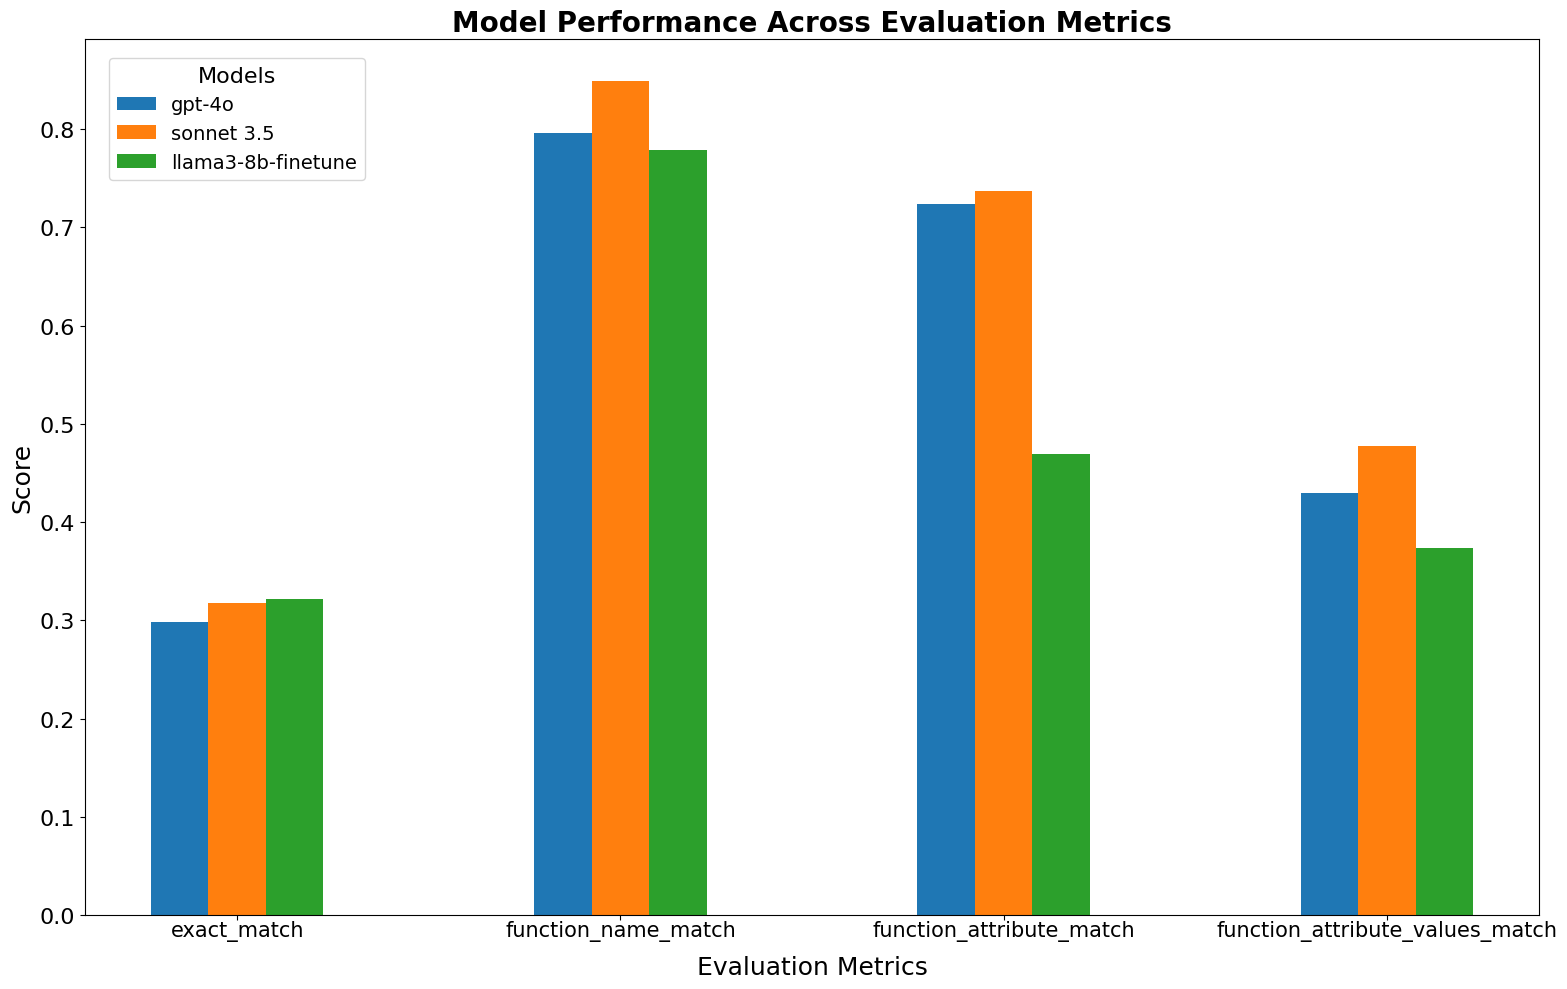

In [43]:
responses_dir = "responses/"
responses_dict_names = {
                        "gpt-4o": "gpt-4o_responses_viggo_val.json",
                        "sonnet 3.5": "sonnet-3.5_responses_viggo_val.json",
                        "llama3-8b-finetune": "llama3-8B_predibase_finetune-1K_2.json"
                        }
all_results = {}                 


for name, responses_file in responses_dict_names.items():
    responses_path = f'{responses_dir}/{responses_file}'
    with open(responses_path, "r") as f:
        responses_dict = json.load(f)
    _, avg_scores = calculate_scores(responses_dict)
    all_results[name] = avg_scores


# Plot all metrics for all models and get the figure
fig = plot_all_model_performance(pd.DataFrame(all_results).T)

# Display the plot (optional)
plt.show()

# # Save the figure
# fig.savefig(f"{out_plot_dir}/all_metrics_comparison.png", dpi=300, bbox_inches='tight')

# # Close the figure to free up memory
# plt.close(fig)

- The initial finetuning of llama-3-8b using 1,000 random examples from the Viggo dataset, while not surpassing GPT-4 and Sonnet 3.5, shows promising results and outperforms several models from our previous blog. 
- **This demonstrates the potential of targeted finetuning even with limited data.**
- There's a big scope of improvement through hyperparameter tuning, dataset distribution changes etc.
- a quick and resource-efficient approach to potentially boost performance is refining the prompt template. A well-crafted prompt can guide the model finetuning more effectively

## Experiment-2 with updated prompt template
Following the initial finetuning experiment, I think I can improve the model's performance by refining the prompt template by providing clearer instructions to the model that conveys what is the structure of functional representation.  The updated prompt template reads:


In [44]:
prompt_template = """Given a target sentence construct the underlying meaningful functional representation of the input sentence as a single function with attributes and attribute values.

### Target sentence: {text}

### Output Functional representation:
"""

### Create and upload the dataset

In [45]:
output_column_name = "functional_representation"
new_df = pd.DataFrame()

prompts = []
for index, row in train_df.iterrows():
    prompt = prompt_template.format(**row.to_dict())
    prompts.append(prompt)

new_df["prompt"] = prompts
new_df["completion"] = train_df[output_column_name]
new_df["split"] = "train"

# similar for validation
prompts = []
for index, row in val_df.iterrows():
    prompt = prompt_template.format(**row.to_dict())
    prompts.append(prompt)
new_df_val = pd.DataFrame()
new_df_val["prompt"] = prompts
new_df_val["completion"] = val_df[output_column_name]
new_df_val["split"] = "evaluation"

# combine train and validation
new_df = pd.concat([new_df, new_df_val])

# change index
new_df.reset_index(drop=True, inplace=True)

print("No. of Train Examplaes: ", len(new_df[new_df["split"] == "train"]), "\nNo. of Eval Examples", len(new_df[new_df["split"] == "evaluation"]))


new_df.head()


No. of Train Examplaes:  900 
No. of Eval Examples 100


,prompt,completion,split
0,Given a target sentence construct the underlyi...,give_opinion(name[Tom Clancy's Splinter Cell: ...,train
1,Given a target sentence construct the underlyi...,"inform(name[Tomb Raider: The Last Revelation],...",train
2,Given a target sentence construct the underlyi...,verify_attribute(name[The Elder Scrolls V: Sky...,train
3,Given a target sentence construct the underlyi...,give_opinion(name[The Elder Scrolls V: Skyrim]...,train
4,Given a target sentence construct the underlyi...,"request_explanation(rating[poor], genres[text ...",train


In [46]:
# sanity check
print(repr(new_df["prompt"][0]))

"Given a target sentence construct the underlying meaningful functional representation of the input sentence as a single function with attributes and attribute values.\n\n### Target sentence: I thought that Tom Clancy's Splinter Cell: Chaos Theory was a pretty fun game. I like tactical action games like it and the M rating meant it didn't need to hold back with its content.\n\n### Output Functional representation:\n"


In [13]:
new_df.to_csv("viggo_train_val_dataset_1K_PromptTempUpdate.csv", index=True)

In [48]:
dataset = pb.datasets.from_file("viggo_train_val_dataset_1K_PromptTempUpdate.csv", name="viggo_train_val_dataset_1K_PromptTempUpdate")

### Finetune and evaluate

In [22]:
# Create an adapter
adapter = pb.adapters.create(
   config=FinetuningConfig(
       base_model="llama-3-8b",
       epochs=3,
       rank=16,
       learning_rate=0.0002,
   ),
   dataset=dataset,
   repo=repo, # use the same repo as before
   description="llama-3-8b-prompt-temp-update",
)

Successfully requested finetuning of llama-3-8b as `viggo-finetune-1K/3`. (Job UUID: c3e4cbf5-12b5-4bd2-9f6e-c28b2428bed7).

Watching progress of finetuning job c3e4cbf5-12b5-4bd2-9f6e-c28b2428bed7. This call will block until the job has finished. Canceling or terminating this call will NOT cancel or terminate the job itself.

Job is starting. Total queue time: 0:00:47         
Waiting to receive training metrics...

┌────────────┬────────────┬─────────────────┐
│ checkpoint │ train_loss │ validation_loss │
├────────────┼────────────┼─────────────────┤
│     1      │   0.6596   │      0.8267     │
│     2      │   0.2259   │      0.3548     │
│     3      │   0.2053   │      0.1601     │
└────────────┴────────────┴─────────────────┘


In [23]:
viggo_dataset = load_dataset("GEM/viggo")
val_dataset = viggo_dataset['validation']

In [27]:
responses_dict = {}
adapter_id = "viggo-finetune-1K/3"
for idx in range(len(val_dataset)):
    if idx % 50 == 0: print(f"Processing {idx}/{len(val_dataset)}")
    output = lorax_client.generate(prompt_template.format(text=val_dataset["target"][idx]), adapter_id=adapter_id, max_new_tokens=150).generated_text
    ground_truth = val_dataset["meaning_representation"][idx]
    text = val_dataset["target"][idx]
    responses_dict[idx] = {"output": output, "ground_truth": ground_truth, "text": text}
    # if idx > 5: break

# write the responses to a json file
with open("llama3-8B_predibase_finetune-1K_3.json", "w") as f:
    json.dump(responses_dict, f)

    

Processing 0/714
Processing 50/714
Processing 100/714
Processing 150/714
Processing 200/714
Processing 250/714
Processing 300/714
Processing 350/714
Processing 400/714
Processing 450/714
Processing 500/714
Processing 550/714
Processing 600/714
Processing 650/714
Processing 700/714


In [50]:
# Save the responses to a JSON file
with open("responses/llama3-8B_predibase_finetune-1K_3.json", "r") as f:
    responses_dict = json.load(f)

In [52]:
_, avg_scores = calculate_scores(responses_dict) # see helper_functions.py
print("\nEvaluation Scores:")
for metric, score in avg_scores.items():
    print(f"{metric:36s}: {score:.4f}")



Evaluation Scores:
exact_match                         : 0.3473
function_name_match                 : 0.7941
function_attribute_match            : 0.5196
function_attribute_values_match     : 0.4202


### Compare the evaluate scores

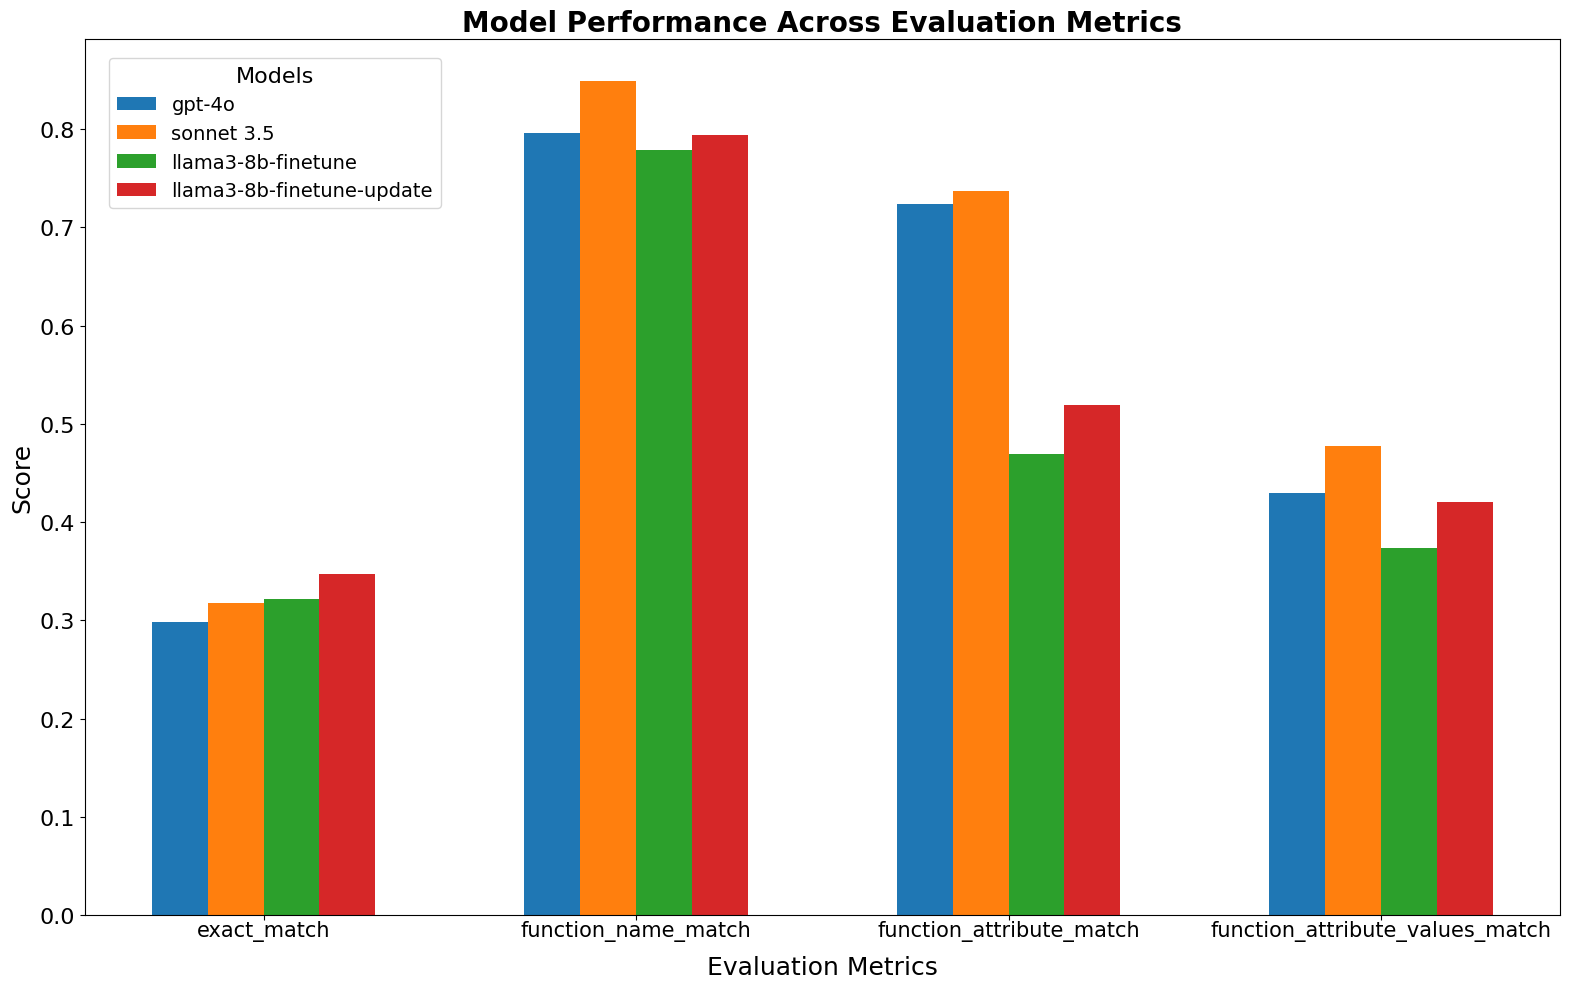

In [54]:
responses_dir = "responses/"
responses_dict_names = {
                        "gpt-4o": "gpt-4o_responses_viggo_val.json",
                        "sonnet 3.5": "sonnet-3.5_responses_viggo_val.json",
                        "llama3-8b-finetune": "llama3-8B_predibase_finetune-1K_2.json",
                        "llama3-8b-finetune-update": "llama3-8B_predibase_finetune-1K_3.json"
                        }
all_results = {}                 


for name, responses_file in responses_dict_names.items():
    responses_path = f'{responses_dir}/{responses_file}'
    with open(responses_path, "r") as f:
        responses_dict = json.load(f)
    _, avg_scores = calculate_scores(responses_dict)
    all_results[name] = avg_scores


# Plot all metrics for all models and get the figure
fig = plot_all_model_performance(pd.DataFrame(all_results).T)

# Display the plot (optional)
plt.show()

The updated prompt template (**llama3-8b-finetune-update**) shows improvements over the initial finetuned model (llama3-8b-finetune) in all metrics. 

## Conclusions

- Predibase offers a user-friendly platform for fine-tuning large language models. I was able to quickly setup and finetune the llm models. While there are some limitations such as restricted hyperparameter tuning, standardized dataset format, and inability to download adapters (in the developer tier), 
- **The overall experience is positive, particularly in terms of rapid finetuning of models.** No need to setup server/docker image or install packages, just focus on finetune! They also over options for dedicated deployment. I would definitely look into it sometime in future.
- I achieve out-of-the-box performance using only random `1K` examples. **This demonstrates the potential of fine-tuning with limited data, highlighting the efficiency of the approach for task-specific model adaptation.**
- Although the fine-tuned llama-3-8b model doesn't match the performance of GPT-4 and Sonnet 3.5, it establishes a strong baseline. The results suggest significant room for improvement even within the constraint of 1,000 examples.

## Next steps..

My next goal is to further explore how much I can improve the performance on evaluation metrics by fine-tuning with a maximum of 1,000 training examples through techniques such as careful diverse example selection, better prompt templates, hyperparameter tuning, and experimenting with different base models.